In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss)
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    original_loss = focal_loss(student_outputs[:,0,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))

    # total loss
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            #loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則創建它
    weights_dir = os.path.join(os.getcwd(), f"weights_KD_segformer_0514_Focal_Loss_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0409(nn.Module):
    def __init__(self,num_classes,backbone="b1",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}

# Student Model: Segformer 0409
model_name = "nvidia/mit-b0"
num_classes = 2
model_segformer = MySegFormer_0409(num_classes)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        teacher_ratio = 0.6
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 [==============================] - 6s 596ms/step - loss: 0.0427
Average validation loss: 0.1218290627002716
4/4 [==============================] - 6s 611ms/step - loss: 0.0427 - val_loss: 0.1218
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_60\segformer_data_size_5.pth'.
Epoch 2/10
4/4 [==============================] - 8s 608ms/step - loss: 0.0319 - val_loss: 0.1218
Average validation loss: 0.11996648460626602
4/4 [==============================] - 8s 622ms/step - loss: 0.0319 - val_loss: 0.1209
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_60\segformer_data_size_5.pth'.
Epoch 3/10
4/4 [==============================] - 11s 590ms/step - loss: 0.0241 - val_loss: 0.1209
Average validation loss: 0.11659226566553116
4/4 [==============================] - 11s 604ms/step - loss: 0.0241 - val_loss: 0.1195
Saved model weights to 'c:\Users\user\Desktop\天

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 [==============================] - 6s 765ms/step - loss: 0.0015
Average validation loss: 0.006787520134821534
8/8 [==============================] - 6s 776ms/step - loss: 0.0015 - val_loss: 0.0068
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_60\segformer_data_size_10.pth'.
Epoch 2/10
8/8 [==============================] - 13s 805ms/step - loss: 0.0014 - val_loss: 0.0068
Average validation loss: 0.1810445636510849
8/8 [==============================] - 13s 815ms/step - loss: 0.0014 - val_loss: 0.0939
Epoch 3/10
8/8 [==============================] - 19s 759ms/step - loss: 0.0013 - val_loss: 0.0939
Average validation loss: 0.10330900177359581
8/8 [==============================] - 19s 771ms/step - loss: 0.0013 - val_loss: 0.0970
Epoch 4/10
8/8 [==============================] - 26s 817ms/step - loss: 0.0013 - val_loss: 0.0970
Average validation loss: 0.14837614446878433
8/8 [==============================] - 26s 83

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 [==============================] - 9s 731ms/step - loss: 0.0015
Average validation loss: 0.15996769070625305
12/12 [==============================] - 9s 741ms/step - loss: 0.0015 - val_loss: 0.1600
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_60\segformer_data_size_15.pth'.
Epoch 2/10
12/12 [==============================] - 18s 735ms/step - loss: 0.0017 - val_loss: 0.1600
Average validation loss: 0.12017138302326202
12/12 [==============================] - 18s 747ms/step - loss: 0.0017 - val_loss: 0.1401
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_60\segformer_data_size_15.pth'.
Epoch 3/10
12/12 [==============================] - 26s 710ms/step - loss: 0.0018 - val_loss: 0.1401
Average validation loss: 0.11502740780512492
12/12 [==============================] - 27s 721ms/step - loss: 0.0018 - val_loss: 0.1317
Saved model weights to 'c:\Use

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 [==============================] - 12s 754ms/step - loss: 0.0015
Average validation loss: 0.12172123603522778
16/16 [==============================] - 12s 767ms/step - loss: 0.0015 - val_loss: 0.1217
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_60\segformer_data_size_20.pth'.
Epoch 2/10
16/16 [==============================] - 24s 716ms/step - loss: 0.0014 - val_loss: 0.1217
Average validation loss: 0.11537623032927513
16/16 [==============================] - 24s 729ms/step - loss: 0.0014 - val_loss: 0.1185
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_60\segformer_data_size_20.pth'.
Epoch 3/10
16/16 [==============================] - 36s 720ms/step - loss: 0.0014 - val_loss: 0.1185
Average validation loss: 0.11345324479043484
16/16 [==============================] - 36s 732ms/step - loss: 0.0014 - val_loss: 0.1169
Saved model weights to 'c:\U

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 [==============================] - 15s 764ms/step - loss: 8.1759e-04
Average validation loss: 0.11636313647031785
20/20 [==============================] - 16s 778ms/step - loss: 8.1759e-04 - val_loss: 0.1164
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_60\segformer_data_size_25.pth'.
Epoch 2/10
20/20 [==============================] - 30s 732ms/step - loss: 8.0856e-04 - val_loss: 0.1164
Average validation loss: 0.11910383701324463
20/20 [==============================] - 31s 743ms/step - loss: 8.0856e-04 - val_loss: 0.1177
Epoch 3/10
20/20 [==============================] - 45s 724ms/step - loss: 8.0225e-04 - val_loss: 0.1177
Average validation loss: 0.11161510944366455
20/20 [==============================] - 45s 735ms/step - loss: 8.0225e-04 - val_loss: 0.1157
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_60\segformer_data_size_25.pth'.
Epoc

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 [==============================] - 17s 714ms/step - loss: 8.5123e-04
Average validation loss: 0.12463439255952835
24/24 [==============================] - 17s 725ms/step - loss: 8.5123e-04 - val_loss: 0.1246
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_60\segformer_data_size_30.pth'.
Epoch 2/10
24/24 [==============================] - 35s 722ms/step - loss: 8.0716e-04 - val_loss: 0.1246
Average validation loss: 0.11777574196457863
24/24 [==============================] - 35s 733ms/step - loss: 8.0716e-04 - val_loss: 0.1212
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_60\segformer_data_size_30.pth'.
Epoch 3/10
24/24 [==============================] - 52s 717ms/step - loss: 7.5926e-04 - val_loss: 0.1212
Average validation loss: 0.12008871758977573
24/24 [==============================] - 53s 727ms/step - loss: 7.5926e-04 - val_loss: 0.1208
Epoc

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 [==============================] - 29s 734ms/step - loss: 0.0011
Average validation loss: 0.10384588092565536
40/40 [==============================] - 30s 747ms/step - loss: 0.0011 - val_loss: 0.1038
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_60\segformer_data_size_50.pth'.
Epoch 2/10
40/40 [==============================] - 59s 727ms/step - loss: 0.0011 - val_loss: 0.1038
Average validation loss: 0.1055518038570881
40/40 [==============================] - 59s 737ms/step - loss: 0.0011 - val_loss: 0.1047
Epoch 3/10
40/40 [==============================] - 88s 721ms/step - loss: 0.0010 - val_loss: 0.1047
Average validation loss: 0.10445793345570564
40/40 [==============================] - 89s 731ms/step - loss: 0.0010 - val_loss: 0.1046
Epoch 4/10
40/40 [==============================] - 117s 716ms/step - loss: 9.7984e-04 - val_loss: 0.1046
Average validation loss: 0.10572459325194358
40/40 [==================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 [==============================] - 35s 725ms/step - loss: 8.2845e-04
Average validation loss: 0.10984702594578266
48/48 [==============================] - 35s 736ms/step - loss: 8.2845e-04 - val_loss: 0.1098
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_60\segformer_data_size_60.pth'.
Epoch 2/10
48/48 [==============================] - 70s 715ms/step - loss: 7.1940e-04 - val_loss: 0.1098
Average validation loss: 0.1287602335214615
48/48 [==============================] - 70s 727ms/step - loss: 7.1940e-04 - val_loss: 0.1193
Epoch 3/10
48/48 [==============================] - 106s 735ms/step - loss: 6.7719e-04 - val_loss: 0.1193
Average validation loss: 0.12555205759902796
48/48 [==============================] - 106s 746ms/step - loss: 6.7719e-04 - val_loss: 0.1214
Epoch 4/10
48/48 [==============================] - 141s 721ms/step - loss: 6.2468e-04 - val_loss: 0.1214
Average validation loss: 0.12995979065696397

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 [==============================] - 40s 715ms/step - loss: 7.8523e-04
Average validation loss: 0.12636125034519605
56/56 [==============================] - 41s 728ms/step - loss: 7.8523e-04 - val_loss: 0.1264
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_60\segformer_data_size_70.pth'.
Epoch 2/10
56/56 [==============================] - 81s 727ms/step - loss: 6.7300e-04 - val_loss: 0.1264
Average validation loss: 0.10911714338830539
56/56 [==============================] - 82s 739ms/step - loss: 6.7300e-04 - val_loss: 0.1177
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_60\segformer_data_size_70.pth'.
Epoch 3/10
56/56 [==============================] - 123s 726ms/step - loss: 6.0206e-04 - val_loss: 0.1177
Average validation loss: 0.11624801052468163
56/56 [==============================] - 124s 738ms/step - loss: 6.0206e-04 - val_loss: 0.1172
Ep

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 [==============================] - 46s 722ms/step - loss: 6.0489e-04
Average validation loss: 0.14178556576371193
64/64 [==============================] - 47s 734ms/step - loss: 6.0489e-04 - val_loss: 0.1418
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_60\segformer_data_size_80.pth'.
Epoch 2/10
64/64 [==============================] - 93s 720ms/step - loss: 5.2782e-04 - val_loss: 0.1418
Average validation loss: 0.12148721376433969
64/64 [==============================] - 94s 732ms/step - loss: 5.2782e-04 - val_loss: 0.1316
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_60\segformer_data_size_80.pth'.
Epoch 3/10
64/64 [==============================] - 141s 731ms/step - loss: 4.6009e-04 - val_loss: 0.1316
Average validation loss: 0.12162409396842122
64/64 [==============================] - 142s 743ms/step - loss: 4.6009e-04 - val_loss: 0.1283
Ep

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 [==============================] - 52s 719ms/step - loss: 5.5234e-04
Average validation loss: 0.11756493482324812
72/72 [==============================] - 53s 730ms/step - loss: 5.5234e-04 - val_loss: 0.1176
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_60\segformer_data_size_90.pth'.
Epoch 2/10
72/72 [==============================] - 105s 721ms/step - loss: 4.8626e-04 - val_loss: 0.1176
Average validation loss: 0.12897349314557183
72/72 [==============================] - 105s 733ms/step - loss: 4.8626e-04 - val_loss: 0.1233
Epoch 3/10
72/72 [==============================] - 157s 716ms/step - loss: 4.5460e-04 - val_loss: 0.1233
Average validation loss: 0.11656857074962722
72/72 [==============================] - 158s 728ms/step - loss: 4.5460e-04 - val_loss: 0.1210
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_60\segformer_data_size_90.pth'.


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 [==============================] - 58s 727ms/step - loss: 9.5089e-04
Average validation loss: 0.1142488144338131
80/80 [==============================] - 59s 739ms/step - loss: 9.5089e-04 - val_loss: 0.1142
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_60\segformer_data_size_100.pth'.
Epoch 2/10
80/80 [==============================] - 117s 726ms/step - loss: 7.4486e-04 - val_loss: 0.1142
Average validation loss: 0.10664532519876957
80/80 [==============================] - 118s 737ms/step - loss: 7.4486e-04 - val_loss: 0.1104
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_60\segformer_data_size_100.pth'.
Epoch 3/10
80/80 [==============================] - 176s 720ms/step - loss: 6.6220e-04 - val_loss: 0.1104
Average validation loss: 0.13600514754652976
80/80 [==============================] - 177s 732ms/step - loss: 6.6220e-04 - val_loss: 0.1190

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 [==============================] - 69s 722ms/step - loss: 8.4191e-04
Average validation loss: 0.12814640502134958
96/96 [==============================] - 71s 733ms/step - loss: 8.4191e-04 - val_loss: 0.1281
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_60\segformer_data_size_120.pth'.
Epoch 2/10
96/96 [==============================] - 139s 716ms/step - loss: 6.5991e-04 - val_loss: 0.1281
Average validation loss: 0.1250244773303469
96/96 [==============================] - 140s 727ms/step - loss: 6.5991e-04 - val_loss: 0.1266
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_60\segformer_data_size_120.pth'.
Epoch 3/10
96/96 [==============================] - 209s 717ms/step - loss: 5.7902e-04 - val_loss: 0.1266
Average validation loss: 0.12543812828759351
96/96 [==============================] - 211s 730ms/step - loss: 5.7902e-04 - val_loss: 0.1262

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 [==============================] - 86s 719ms/step - loss: 5.2499e-04
Average validation loss: 0.13352259596188862
120/120 [==============================] - 88s 731ms/step - loss: 5.2499e-04 - val_loss: 0.1335
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_60\segformer_data_size_150.pth'.
Epoch 2/10
120/120 [==============================] - 175s 725ms/step - loss: 4.7720e-04 - val_loss: 0.1335
Average validation loss: 0.12593633929888406
120/120 [==============================] - 176s 736ms/step - loss: 4.7720e-04 - val_loss: 0.1297
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_60\segformer_data_size_150.pth'.
Epoch 3/10
120/120 [==============================] - 263s 726ms/step - loss: 4.2517e-04 - val_loss: 0.1297
Average validation loss: 0.132144529124101
120/120 [==============================] - 265s 738ms/step - loss: 4.2517e-04 - val_l

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 [==============================] - 104s 720ms/step - loss: 5.3007e-04
Average validation loss: 0.1321601528260443
144/144 [==============================] - 106s 732ms/step - loss: 5.3007e-04 - val_loss: 0.1322
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_60\segformer_data_size_180.pth'.
Epoch 2/10
144/144 [==============================] - 209s 718ms/step - loss: 4.5141e-04 - val_loss: 0.1322
Average validation loss: 0.12630094380842316
144/144 [==============================] - 211s 730ms/step - loss: 4.5141e-04 - val_loss: 0.1292
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_60\segformer_data_size_180.pth'.
Epoch 3/10
144/144 [==============================] - 314s 720ms/step - loss: 4.2615e-04 - val_loss: 0.1292
Average validation loss: 0.13942422717809677
144/144 [==============================] - 316s 732ms/step - loss: 4.2615e-04 - va

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 [==============================] - 115s 718ms/step - loss: 3.6110e-04
Average validation loss: 0.1277244096621871
160/160 [==============================] - 117s 729ms/step - loss: 3.6110e-04 - val_loss: 0.1277
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_60\segformer_data_size_200.pth'.
Epoch 2/10
160/160 [==============================] - 232s 721ms/step - loss: 3.2739e-04 - val_loss: 0.1277
Average validation loss: 0.13402189556509256
160/160 [==============================] - 234s 732ms/step - loss: 3.2739e-04 - val_loss: 0.1309
Epoch 3/10
160/160 [==============================] - 349s 721ms/step - loss: 2.9331e-04 - val_loss: 0.1309
Average validation loss: 0.13140878714621068
160/160 [==============================] - 351s 733ms/step - loss: 2.9331e-04 - val_loss: 0.1311
Epoch 4/10
160/160 [==============================] - 466s 716ms/step - loss: 2.7085e-04 - val_loss: 0.1311
Average validation loss: 

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 [==============================] - 144s 719ms/step - loss: 6.3135e-04
Average validation loss: 0.1350496655702591
200/200 [==============================] - 146s 730ms/step - loss: 6.3135e-04 - val_loss: 0.1350
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_60\segformer_data_size_250.pth'.
Epoch 2/10
200/200 [==============================] - 290s 719ms/step - loss: 5.1736e-04 - val_loss: 0.1350
Average validation loss: 0.13279782250523567
200/200 [==============================] - 292s 731ms/step - loss: 5.1736e-04 - val_loss: 0.1339
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_60\segformer_data_size_250.pth'.
Epoch 3/10
200/200 [==============================] - 436s 716ms/step - loss: 4.5735e-04 - val_loss: 0.1339
Average validation loss: 0.12675369560718536
200/200 [==============================] - 438s 728ms/step - loss: 4.5735e-04 - va

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  1/240 [..............................] - ETA: 3:06 - loss: 3.2921e-04

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 [==============================] - 174s 723ms/step - loss: 4.7591e-04
Average validation loss: 0.1508426435291767
240/240 [==============================] - 176s 734ms/step - loss: 4.7591e-04 - val_loss: 0.1508
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_60\segformer_data_size_300.pth'.
Epoch 2/10
240/240 [==============================] - 349s 720ms/step - loss: 4.0262e-04 - val_loss: 0.1508
Average validation loss: 0.13080190382897855
240/240 [==============================] - 352s 732ms/step - loss: 4.0262e-04 - val_loss: 0.1408
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_60\segformer_data_size_300.pth'.
Epoch 3/10
240/240 [==============================] - 525s 719ms/step - loss: 3.5235e-04 - val_loss: 0.1408
Average validation loss: 0.13517023945848147
240/240 [==============================] - 528s 731ms/step - loss: 3.5235e-04 - va

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.1308165702968836, 0.09041652268962935, 0.11094272141655286, 0.11402171425521374, 0.1195869493186474, 0.11499015726149082, 0.11874834114313128, 0.1195424454472959, 0.12467669696680136, 0.12522586407139896, 0.12261560845706197, 0.12658111391961574, 0.12956616911416252, 0.12941142546137174, 0.13174271016485162, 0.1331690384224057, 0.13596221188008786, 0.13784209802995126]
std_val_losses =  [0.03975540707621945, 0.05005574285176388, 0.022204610730842667, 0.014600646964888614, 0.013451656836395702, 0.009555472605359237, 0.008723431046639933, 0.0091355263403546, 0.0070389781936241545, 0.008159666570191449, 0.01049848694816819, 0.005305593805814128, 0.003991523530152543, 0.003948952539663364, 0.005231462373957965, 0.0041495957174769935, 0.00527559256526693, 0.00394273578767789]


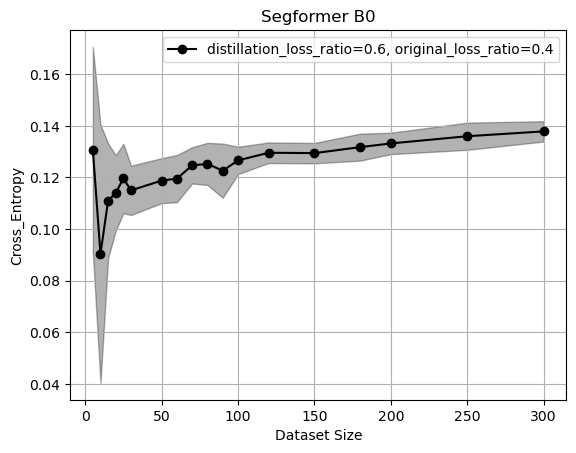

In [17]:
print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.show()